# Adel Movahedian & Mehdi zolfaghari

### 1.Data Preprocessing

There are many ways to load MNIST , for this particular task I preferred to load it from Scikit-learn datasets.

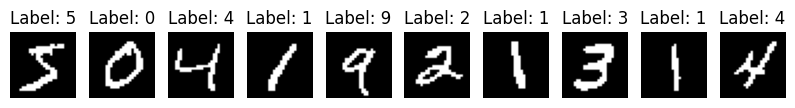

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def preprocess_mnist(threshold=128):
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train_images = train_images.reshape(-1, 28 * 28) / 255.0
    test_images = test_images.reshape(-1, 28 * 28) / 255.0

    train_images = (train_images > threshold / 255.0).astype(np.float32)
    test_images = (test_images > threshold / 255.0).astype(np.float32)

    return train_images, train_labels, test_images, test_labels

def show_samples(images, labels, num_samples=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

train_images, train_labels, test_images, test_labels = preprocess_mnist()

show_samples(train_images, train_labels, num_samples=10)


### 2,3. Algorithm Implementation and Learning and gif generation


In below section we try to implement.


 RBM with k = 1 ...
Epoch 1/10 completed. Loss: 0.0967
Epoch 2/10 completed. Loss: 0.0707
Epoch 3/10 completed. Loss: 0.0641
Epoch 4/10 completed. Loss: 0.0603
Epoch 5/10 completed. Loss: 0.0574
Epoch 6/10 completed. Loss: 0.0556
Epoch 7/10 completed. Loss: 0.0539
Epoch 8/10 completed. Loss: 0.0526
Epoch 9/10 completed. Loss: 0.0515
Epoch 10/10 completed. Loss: 0.0506


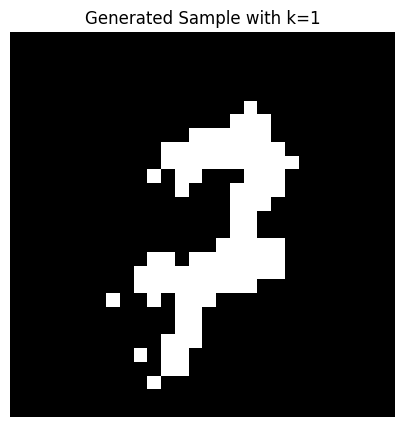

Saved GIF for k = 1 as rbm reconstruction process for k = 1.gif

 RBM with k = 5 ...
Epoch 1/10 completed. Loss: 0.0675
Epoch 2/10 completed. Loss: 0.0671
Epoch 3/10 completed. Loss: 0.0669
Epoch 4/10 completed. Loss: 0.0665
Epoch 5/10 completed. Loss: 0.0658
Epoch 6/10 completed. Loss: 0.0653
Epoch 7/10 completed. Loss: 0.0649
Epoch 8/10 completed. Loss: 0.0643
Epoch 9/10 completed. Loss: 0.0641
Epoch 10/10 completed. Loss: 0.0635


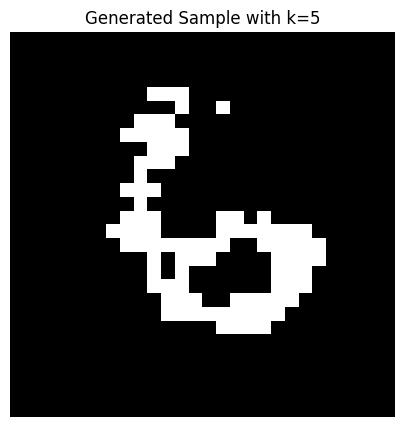

Saved GIF for k = 5 as rbm reconstruction process for k = 5.gif

 RBM with k = 10 ...
Epoch 1/10 completed. Loss: 0.0718
Epoch 2/10 completed. Loss: 0.0718
Epoch 3/10 completed. Loss: 0.0715
Epoch 4/10 completed. Loss: 0.0711
Epoch 5/10 completed. Loss: 0.0710
Epoch 6/10 completed. Loss: 0.0707
Epoch 7/10 completed. Loss: 0.0703
Epoch 8/10 completed. Loss: 0.0702
Epoch 9/10 completed. Loss: 0.0701
Epoch 10/10 completed. Loss: 0.0698


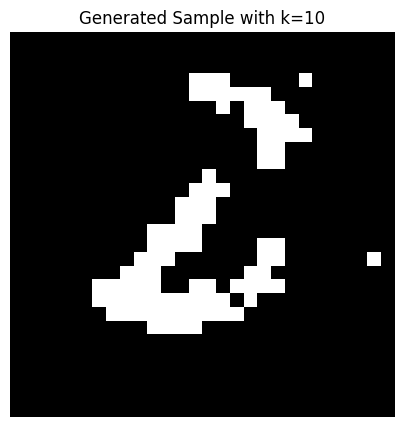

Saved GIF for k = 10 as rbm reconstruction process for k = 10.gif


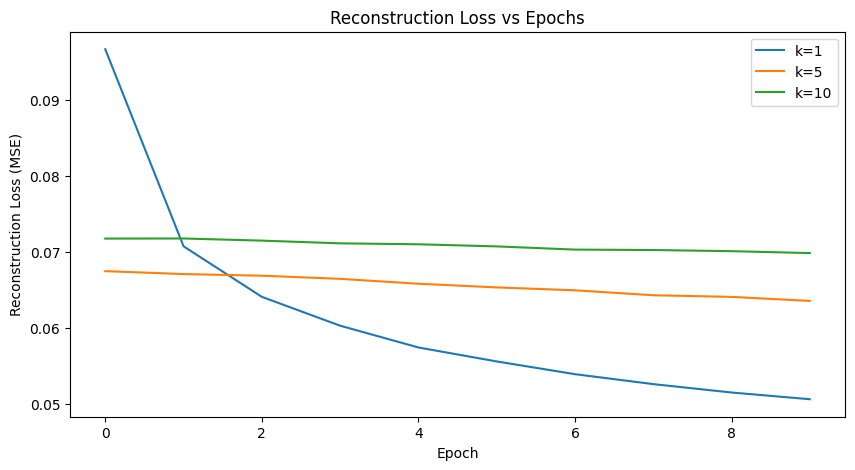

In [42]:
from scipy.special import expit  # Stable sigmoid
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import random


class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.weights = np.random.normal(0, np.sqrt(2 / (n_visible + n_hidden)), (n_visible, n_hidden))  # Xavier Initialization
        self.h_bias = np.zeros(n_hidden)
        self.v_bias = np.zeros(n_visible)
        self.sample_trajectory = []

    def sigmoid(self, x):
        return expit(x)

    def sample_prob(self, probs):
        return np.random.binomial(1, probs)

    def forward(self, v):
        return self.sigmoid(np.dot(v, self.weights) + self.h_bias)

    def backward(self, h):
        return self.sigmoid(np.dot(h, self.weights.T) + self.v_bias)

    def contrastive_divergence(self, v0, k=1, track_trajectory=True):
        vk = v0.copy()
        trajectory = []
        for step in range(k):
            h = self.sample_prob(self.forward(vk))
            vk = self.sample_prob(self.backward(h))
            if track_trajectory:
                trajectory.append(vk.copy())
        if track_trajectory:
            self.sample_trajectory.append(trajectory)
        return vk

    def train(self, data, k=1, epochs=10):
        self.sample_trajectory = []  #Clear previous trajectory
        reconstruction_losses = []
        for epoch in range(epochs):
            epoch_loss = 0
            for v0 in data:
                v0 = v0.flatten()
                vk = self.contrastive_divergence(v0, k, track_trajectory=(epoch == epochs - 1))
                ph0 = self.forward(v0)
                phk = self.forward(vk)

                self.weights += self.learning_rate * (np.outer(v0, ph0) - np.outer(vk, phk))
                self.v_bias += self.learning_rate * (v0 - vk)
                self.h_bias += self.learning_rate * (ph0 - phk)

                epoch_loss += np.mean((v0 - vk) ** 2)

            reconstruction_losses.append(epoch_loss / len(data))
            print(f"Epoch {epoch + 1}/{epochs} completed. Loss: {reconstruction_losses[-1]:.4f}")
        return reconstruction_losses

    def generate_samples(self, v0, k=100):
        self.sample_trajectory = []  #Clear trajectory for new sampling
        samples = self.contrastive_divergence(v0, k, track_trajectory=True)
        return samples


n_visible = 28 * 28
n_hidden = 128
learning_rate = 0.01
epochs = 10
rbm = RBM(n_visible, n_hidden, learning_rate)
k_values = [1, 5, 10]
losses = {}

for k in k_values:
    print(f"\n RBM with k = {k} ...")
    losses[k] = rbm.train(train_images[:10000].reshape(-1, 28 * 28), k=k, epochs=epochs)  #first 10000 images
    index = random.randint(0, 10000)
    v0 = train_images[index].flatten()
    rbm.generate_samples(v0, k)
    generated_sample = rbm.generate_samples(v0, k)

    plt.figure(figsize=(5, 5))
    plt.imshow(generated_sample.reshape(28, 28), cmap='gray')
    plt.title(f"Generated Sample with k={k}")
    plt.axis('off')
    plt.show()
    fig, ax = plt.subplots()
    im = ax.imshow(rbm.sample_trajectory[0][0].reshape(28, 28), cmap="gray", interpolation="none")
    ax.axis("off")

    def update(frame):
        v = rbm.sample_trajectory[0][frame].reshape(28, 28)
        im.set_array(v)
        ax.set_title(f"Step {frame + 1}")
        return [im]

    plt.close(fig)
    frames = len(rbm.sample_trajectory[0])
    ani = FuncAnimation(fig, update, frames=frames, interval=200, blit=True)
    gif_filename = f"rbm reconstruction process for k = {k}.gif"
    ani.save(gif_filename, writer=PillowWriter(fps=10))
    print(f"Saved GIF for k = {k} as {gif_filename}")

plt.figure(figsize=(10, 5))
for k, loss in losses.items():
    plt.plot(loss, label=f"k={k}")
plt.title("Reconstruction Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.legend()
plt.show()


<font color='green'>K=1 seems to perform very well on MNIST dataset</font>

### 4. Control Over Generated Samples

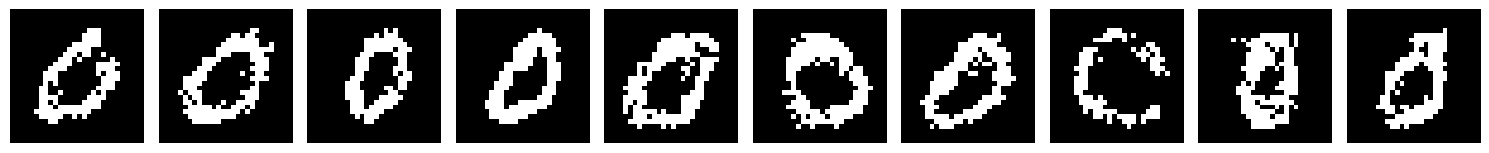

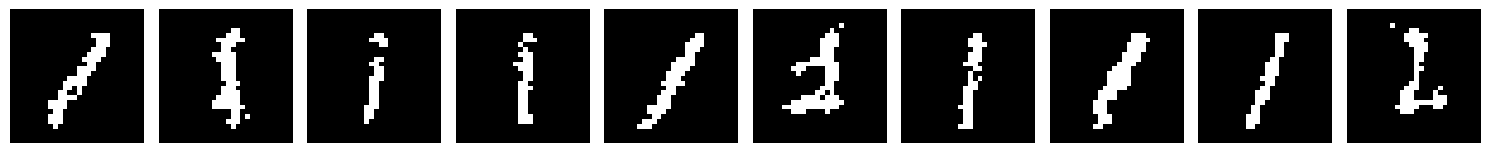

In [52]:
def generate_digit_samples(rbm, digit, num_samples=10, k=10):
    digit_indices = np.flatnonzero(train_labels == digit)[:num_samples]
    seed_images = train_images[digit_indices]
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for idx, (ax, seed) in enumerate(zip(axes, seed_images)):
        vk = rbm.contrastive_divergence(seed.flatten(), k)
        generated_sample = vk
        ax.imshow(generated_sample.reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_xlabel(f"Digit {digit} - Sample {idx + 1}", fontsize=10)
    plt.tight_layout()
    plt.show()
for target_digit in range(2):
    generate_digit_samples(rbm, target_digit)


<font color='green'>This approach leverages a trained Restricted Boltzmann Machine (RBM) to generate digit-specific samples by initializing the generation process with seed images of the target digit. The method begins by identifying indices of images corresponding to the desired digit in the dataset, ensuring that the generated samples are controlled and contextually relevant. Each seed image undergoes Gibbs sampling through the RBM's contrastive divergence algorithm, which iteratively refines the visible states based on the hidden layer's activations. This process outputs reconstructed samples that are reshaped and visualized as grayscale images. A key aspect of this approach is its reliance on the RBM's learned weight matrix to guide the sampling trajectory toward realistic representations of the input digit. By controlling the initialization and number of sampling steps, this method enables targeted generation of specific digit patterns while maintaining flexibility in exploring variations influenced by the learned latent space.</font>